## Определение перспективного тарифа для телеком компании
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.  

### Описание тарифов
##### Тариф «Смарт»
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 3 рубля  
сообщение: 3 рубля  
1 Гб интернет-трафика: 200 рублей  
##### Тариф «Ультра»
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 1 рубль  
сообщение: 1 рубль  
1 Гб интернет-трафика: 150 рублей  

Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Описание данных

Таблица `users` (информация о пользователях):  
- user_id — уникальный идентификатор пользователя  
- first_name — имя пользователя  
- last_name — фамилия пользователя  
- age — возраст пользователя (годы)  
- reg_date — дата подключения тарифа (день, месяц, год)  
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных) 
- city — город проживания пользователя  
- tariff — название тарифного плана  

Таблица `calls` (информация о звонках):  
- id — уникальный номер звонка  
- call_date — дата звонка  
- duration — длительность звонка в минутах  
- user_id — идентификатор пользователя, сделавшего звонок  

Таблица `messages` (информация о сообщениях):  
- id — уникальный номер сообщения  
- message_date — дата сообщения  
- user_id — идентификатор пользователя, отправившего сообщение 

Таблица `internet` (информация об интернет-сессиях):  
- id — уникальный номер сессии  
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
- session_date — дата интернет-сессии  
- user_id — идентификатор пользователя  

Таблица `tariffs` (информация о тарифах):  
- tariff_name — название тарифа  
- rub_monthly_fee — ежемесячная абонентская плата в рублях  
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
- messages_included — количество сообщений в месяц, включённых в абонентскую плату  
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  

### Оглавление
1 <a href = '#open'>Изучение общей информации</a>  
2 <a href = '#preparation'>Подготовка данных</a>  
&ensp; 2.1 <a href = '#feature'>Добавление новых данных</a>  
3 <a href = '#analysis'>Анализ данных</a>  
4 <a href = '#hypothesis_testing'>Тестирование гипотез</a>  
5 <a href = '#conclusion'>Вывод</a>  

### Шаг 1. Изучение общей информации
<a id = open></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [9]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


#### Вывод
Пропуски обнаружены только в таблице `users`, колонке `churn_date`. Пропуски в этой колонке означают продолжение использования тарифа.  
Неверные типы имеют столбцы с датами.

### Шаг 2. Подготовка данных
<a id = 'preparation'></a>

Изменим тип столбцов с датами с object на datetime

In [12]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

Приведем значения текстовых столбцов таблицы `users` к нижнему регистру.

In [13]:
users['city'] = users['city'].str.lower()
users['first_name'] = users['first_name'].str.lower()
users['last_name'] = users['last_name'].str.lower()
users['tariff'] = users['tariff'].str.lower()

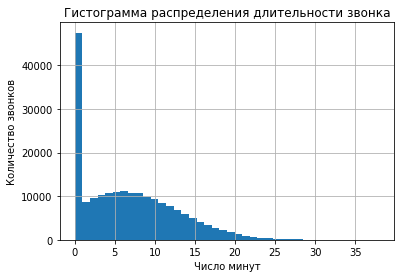

In [14]:
calls['duration'].hist(bins = 40)
plt.title('Гистограмма распределения длительности звонка')
plt.xlabel('Число минут')
plt.ylabel('Количество звонков')
plt.show()

In [15]:
len(calls[calls['duration']==0])/len(calls['duration'])

0.19551644316336553

In [16]:
calls = calls.query('duration!=0')

#### Вывод
Столбец `duration` содержит множество нулей, такие значения составляют 20%, это пользователи, которые не дозвонились. Мы удалили эти значения, чтобы получить впоследствии точнее среднее значение и не учитывать такие звонки в общем числе звонков.
Заполнить столбец мы `churn_date` мы не можем, отсутствие значения в этом стоблце показывает, что тарифом еще пользуются.


In [17]:
len(internet[internet['mb_used']==0])/len(internet)

0.13118155773916304

In [18]:
internet = internet.query('mb_used!=0')

Обнаружены значения использованных Мб 0 на сессию. Похоже, что это сбои сети и в эти сессии не был использован трафик. Таких значений немного, удалим их.

In [19]:
calls['duration'] = np.ceil(calls['duration']).astype(int)

In [20]:
internet['mb_used'] = np.ceil(internet['mb_used'])

### Добавление новых данных
<a id = 'feature'></a>

Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам

In [21]:
calls['month'] = calls['call_date'].dt.month

In [22]:
df = calls.groupby(['user_id','month']).sum()
count_call = calls.groupby(['user_id','month'])['id'].count()
df_call = df.join(count_call, how = 'outer', on = ['user_id','month'])

In [23]:
df_call.columns = ['sum_minutes', 'count_calls']

In [24]:
df_call = df_call.reset_index()

Посчитаем количество отправленных сообщений по месяцам

In [25]:
messages['month'] = messages['message_date'].dt.month

In [26]:
df_message = messages.groupby(['user_id','month'])['id'].count()
df_message = df_message.reset_index()
df_message.columns = ['user_id', 'month', 'count_message']

Посчитаем объем израсходованного интернет-трафика по месяцам

In [27]:
internet['month'] = internet['session_date'].dt.month
internet = internet.drop(['Unnamed: 0'], axis = 1)
df_internet = internet.groupby(['user_id','month']).sum()
df_internet.columns = ['sum_internet']
df_internet = df_internet.reset_index()

In [28]:
df_internet['sum_internet'] = df_internet['sum_internet'] / 1024

Объединим таблицы

In [29]:
data = df_call.merge(df_message, on = ['user_id', 'month'],  how = 'outer')
data = data.merge(df_internet, on = ['user_id', 'month'],  how = 'outer')
data = data.merge(users, on = ['user_id'], how = 'outer')

Нашли людей, подключившихся и не воспользовавшись тарифом отключившихся, удалим их

In [30]:
data = data.drop(data[data['month'].isna()].index,axis = 0)

Столбцы sum_minutes, count_calls, count_message, sum_internet содержат пропуски. Их мы получили при объединении таблиц. Nan в этих колонках означает, что минуты, Гб или сообщения не использовались. Заменим эти значения на 0.

In [31]:
data = data.fillna(0)
data['month'] = data['month'].astype(int)
data['count_calls'] = data['count_calls'].astype(int)
data['count_message'] = data['count_message'].astype(int)
data['sum_minutes'] = data['sum_minutes'].astype(int)

In [32]:
data.head(10)

,user_id,month,sum_minutes,count_calls,count_message,sum_internet,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,159,17,22,2.203125,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra
1,1000,6,172,28,60,22.711914,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra
2,1000,7,340,41,75,13.687500,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra
3,1000,8,408,42,81,13.740234,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra
4,1000,9,466,46,57,14.239258,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra
5,1000,10,350,44,73,14.372070,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra
6,1000,11,338,37,58,14.421875,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra
7,1000,12,333,38,70,9.596680,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra
8,1001,11,430,45,0,18.019531,41,0,москва,иван,ежов,2018-11-01,smart
9,1001,12,414,47,0,13.723633,41,0,москва,иван,ежов,2018-11-01,smart


Посчитаем помесячную выручку каждого с пользователя 

In [33]:
tariffs.index = ['smart','ultra']
dict_tariffs =  tariffs.to_dict()

In [34]:
def revenue_month_user(row):
    tarif_name = row['tariff']
    unpaid_minutes = row['sum_minutes'] - dict_tariffs['minutes_included'][tarif_name] 
    unpaid_message = row['count_message'] - dict_tariffs['messages_included'][tarif_name]
    unpaid_internet = row['sum_internet'] - dict_tariffs['mb_per_month_included'][tarif_name] / 1024
    addFee_minutes, addFee_message, addFee_internet = 0,0,0
    if unpaid_minutes > 0:
        addFee_minutes = unpaid_minutes * dict_tariffs['rub_per_minute'][tarif_name]
    if unpaid_message > 0:
        addFee_message = unpaid_message * dict_tariffs['rub_per_message'][tarif_name]
    if unpaid_internet > 0:
        addFee_internet = unpaid_internet * dict_tariffs['rub_per_gb'][tarif_name]
    revenue = addFee_minutes + addFee_message + addFee_internet + dict_tariffs['rub_monthly_fee'][tarif_name]
    return revenue

In [35]:
data['revenue'] = data.apply(revenue_month_user, axis = 1).astype(int)

In [36]:
data.head(10)

,user_id,month,sum_minutes,count_calls,count_message,sum_internet,age,churn_date,city,first_name,last_name,reg_date,tariff,revenue
0,1000,5,159,17,22,2.203125,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra,1950
1,1000,6,172,28,60,22.711914,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra,1950
2,1000,7,340,41,75,13.687500,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra,1950
3,1000,8,408,42,81,13.740234,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra,1950
4,1000,9,466,46,57,14.239258,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra,1950
5,1000,10,350,44,73,14.372070,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra,1950
6,1000,11,338,37,58,14.421875,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra,1950
7,1000,12,333,38,70,9.596680,52,0,краснодар,рафаил,верещагин,2018-05-25,ultra,1950
8,1001,11,430,45,0,18.019531,41,0,москва,иван,ежов,2018-11-01,smart,1153
9,1001,12,414,47,0,13.723633,41,0,москва,иван,ежов,2018-11-01,smart,550


In [37]:
data = data.drop(['age', 'churn_date', 'first_name', 'last_name', 'reg_date'], axis = 1)

### Шаг 3. Анализ данных
<div id = 'analysis'>

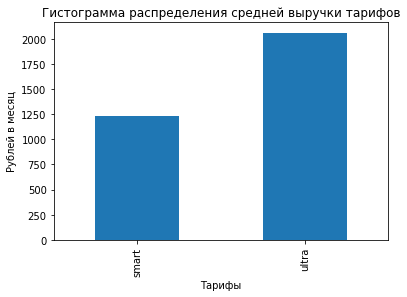

In [38]:
data.groupby(['tariff'])['revenue'].mean().plot(kind = 'bar')
plt.title('Гистограмма распределения средней выручки тарифов')
plt.xlabel('Тарифы')
plt.ylabel('Рублей в месяц')
plt.show()

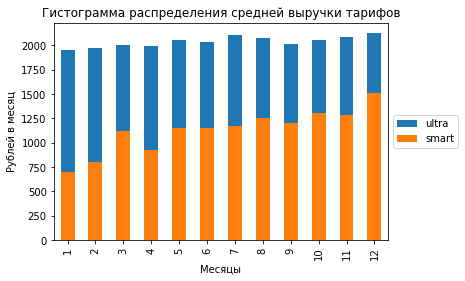

In [39]:
data.query('tariff == "ultra"').groupby(['month'])['revenue'].mean().plot(kind = 'bar')
data.query('tariff == "smart"').groupby(['month'])['revenue'].mean().plot(kind = 'bar', color = 'tab:orange')
plt.legend(['ultra','smart'], bbox_to_anchor=(1, 0.6))
plt.title('Гистограмма распределения средней выручки тарифов')
plt.xlabel('Месяцы')
plt.ylabel('Рублей в месяц')
plt.show()

Исследуем среднюю продолжительность звонка в разных тарифах

In [40]:
data.groupby('tariff')['sum_minutes'].mean() / data.groupby('tariff')['count_calls'].mean()

tariff
smart    8.902175
ultra    8.890176
dtype: float64

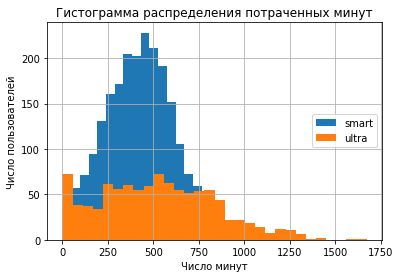

In [41]:
data.groupby('tariff')['sum_minutes'].hist(bins = 30)
plt.title('Гистограмма распределения потраченных минут')
plt.xlabel('Число минут')
plt.ylabel('Число пользователей')
plt.legend(['smart','ultra'], bbox_to_anchor=(1, 0.6))
plt.show()

In [42]:
pivot_data = []
def interval(name, col):
    mean = data.query('tariff == @name')[col].mean()
    std = np.std(data.query('tariff == @name')[col])
    pivot_data.append([col, name, mean, std, mean-3*std, mean+3*std])
    print(mean-3*std, '-', mean+3*std, 'Среднее:', mean)

In [43]:
print("Для суммы минут интервал тарифа smart:")
interval("smart", 'sum_minutes')
print("Для суммы минут интервал тарифа ultra:")
interval("ultra", 'sum_minutes')

Для суммы минут интервал тарифа smart:
-152.87815574219866 - 988.7480525569138 Среднее: 417.9349484073576
Для суммы минут интервал тарифа ultra:
-425.7111563954163 - 1478.9578569030305 Среднее: 526.6233502538071


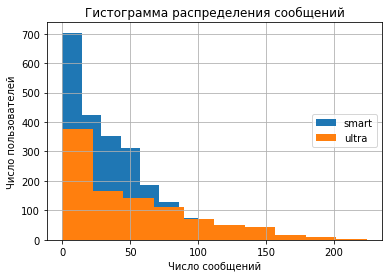

In [44]:
data.groupby('tariff')['count_message'].hist()
plt.title('Гистограмма распределения сообщений')
plt.xlabel('Число сообщений')
plt.ylabel('Число пользователей')
plt.legend(['smart','ultra'], bbox_to_anchor=(1, 0.6))
plt.show()

In [45]:
print("Для числа сообщений интервал тарифа smart:")
interval("smart", 'count_message')
print("Для числа сообщений интервал тарифа ultra:")
interval("ultra", 'count_message')

Для числа сообщений интервал тарифа smart:
-51.280599948269725 - 118.04865737312392 Среднее: 33.384028712427096
Для числа сообщений интервал тарифа ultra:
-93.97710312165506 - 192.70400667495457 Среднее: 49.36345177664975


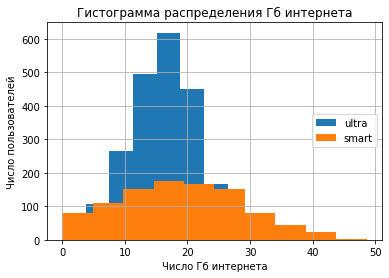

In [46]:
data.groupby('tariff')['sum_internet'].hist()
plt.title('Гистограмма распределения Гб интернета')
plt.xlabel('Число Гб интернета')
plt.ylabel('Число пользователей')
plt.legend(['ultra','smart'], bbox_to_anchor=(1, 0.6))
plt.show()

In [47]:
print("Для Гб интернета интервал тарифа smart:")
interval("smart", 'sum_internet')
print("Для Гб интернета интервал тарифа ultra:")
interval("ultra", 'sum_internet')

Для Гб интернета интервал тарифа smart:
-1.3667839480659012 - 33.06441759123548 Среднее: 15.84881682158479
Для Гб интернета интервал тарифа ultra:
-10.533858473869515 - 48.594213010671545 Среднее: 19.030177268401015


In [48]:
pd.DataFrame(columns = ['показатель',
                        'тариф',
                        'среднее',
                        'ст откл',
                        'левая гр интервала',
                        'правая гр интервала'],
             data = pivot_data)

,показатель,тариф,среднее,ст откл,левая гр интервала,правая гр интервала
0,sum_minutes,smart,417.934948,190.271035,-152.878156,988.748053
1,sum_minutes,ultra,526.623350,317.444836,-425.711156,1478.957857
2,count_message,smart,33.384029,28.221543,-51.280600,118.048657
3,count_message,ultra,49.363452,47.780185,-93.977103,192.704007
4,sum_internet,smart,15.848817,5.738534,-1.366784,33.064418
5,sum_internet,ultra,19.030177,9.854679,-10.533858,48.594213


#### Вывод
Проанализаровав данные мы выяснили, что средняя выручка тарифа Ультра(2000 руб) выше тарифа Смарт(1250 руб).  
В 2018 году прослеживается рост средней выручки от тарифа Смарт. Средняя продолжительность звонка одинакова в двух тарифах(8.4 минуты) 

Исследовали распределение минут разговора. Распределение в тарифе Смарт нормальное с небольшой положительной скошенностью.В тарифе Ультра равномерное распределение. В среденем использование минут тарифа Смарт 394 минуты, Ультра - 497 минут, 99% звонков Тарифа Смарт укладывается в 934 минуты, Ультра - 1396 минут.  

Исследовали распределение сообщений. Число сообщений распределено по закону Пуассона. В среднем число сообщений за месяц в тарифе Смарт - 33, Ультра - 49, 99% пользователей Тарифа Смарт отправляют меньше 118 сообщений, Тарифа Ультра - 193 сообщений. 

Исследовали распределение использованного трафика. Распределение нормальное. В среднем пользователи тарифа Смарт расходуют 16 Гб интернета, тарифа Ультра - 19 Гб. 99% распределения укладывается до 33 в тарифе Смарт, 49 в тарифе Ультра.

### Шаг 4. Проверка гипотез
<a id = 'hypothesis_testing'></a>

Проверим гипотезу - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна - H0  
Гипотеза H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается  
Проверим гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, выручка тарифа `smart` и тарифа `ultra`, применим метод `scipy.stats.ttest_ind()`

In [49]:
disp1 = np.var(data.query('tariff == "smart"')['revenue'])
disp2 = np.var(data.query('tariff == "ultra"')['revenue'])
print(disp1, disp2)

619947.3501724182 126740.64659640804


Дисперсии выборок существенно отличаются, укажем equal_var = False

In [50]:
results = st.ttest_ind(data.query('tariff == "smart"')['revenue'], 
                       data.query('tariff == "ultra"')['revenue'], 
                       equal_var = False)
print('p-значение: ', results.pvalue)

p-значение:  5.133013116078655e-296


Проверим гипотезу - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов - H0    
Альтернативная гипотеза H1 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
Проверим гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, выручка в Москве и в регионах, применим метод `scipy.stats.ttest_ind()`

In [51]:
moscow = data.query('city == "москва"')
regions = data.query('city != "москва"')

In [52]:
disp1 = np.var(moscow['revenue'])
disp2 = np.var(regions['revenue'])
print(disp1, disp2)

546237.2279030647 630158.78585674


Дисперсии выборок примерно равны, выборки взяты из схожих по параметрам совокупностей, укажем equal_var = True

In [53]:
results = st.ttest_ind(regions['revenue'], moscow['revenue'], equal_var = True)
print('p-значение: ', results.pvalue)

p-значение:  0.4741107329003996


#### Вывод
Для уровня значимости p = 0.05 гипотеза H0 о равной средней выручки тарифов Смарт И Ультра отвергается, принимается альтеранивная, H1 о различиях средней выручки тарифов Смарт и Ультра.  
Гипотеза о равенстве  средней выручки пользователей в Москве и других регионов при уровне значимости p = 0.05 не отвергается.

### Шаг 5. Формулирование выводов
<a id = 'conclusion'></a>

Мы анализировали данные мобильного оператора по выборке из 500 пользователям двух тарифов "Смарт" и "Ультра".  

Пропуски обнаружены только в таблице users, колонке churn_date. Неверные типы имеют столбцы с датами. 
Столбец duration содержит множество нулей, такие значения составляют 20%, это пользователи, которые не дозвонились. Мы удалили эти значения, чтобы получить впоследствии точнее среднее значение и не учитывать такие звонки в общем числе звонков. Заполнить столбец мы churn_date мы не можем, отсутствие значения в этом стоблце показывает, что тарифом еще пользуются.  

Для анализа мы посчиатли дополнительные данные и объединили информацию из таблиц. Посчитали количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам, помесячную выручку каждого с пользователя. Обнаружили людей, подключившихся и не воспользовавшись тарифом отключившихся.  

Проанализаровав данные мы выяснили, что средняя выручка тарифа Ультра(2000 руб) выше тарифа Смарт(1250 руб).
В 2018 году прослеживается рост средней выручки от тарифа Смарт. Средняя продолжительность звонка одинакова в двух тарифах(8.4 минуты)  

Исследовали распределение минут разговора. Распределение в тарифе Смарт нормальное с небольшой положительной скошенностью.В тарифе Ультра равномерное распределение. В среденем использование минут тарифа Смарт 394 минуты, Ультра - 497 минут, 99% звонков Тарифа Смарт укладывается в 934 минуты, Ультра - 1396 минут.  

Исследовали распределение сообщений. Число сообщений распределено по закону Пуассона. В среднем число сообщений за месяц в тарифе Смарт - 33, Ультра - 49, 99% пользователей Тарифа Смарт отправляют меньше 118 сообщений, Тарифа Ультра - 193 сообщений.

Исследовали распределение использованного трафика. Распределение нормальное. В среднем пользователи тарифа Смарт расходуют 16 Гб интернета, тарифа Ультра - 19 Гб. 99% распределения укладывается до 33 в тарифе Смарт, 49 в тарифе Ультра.

Мы провели проверку гипотез.  
Для уровня значимости p = 0.05 гипотеза H0 о равной средней выручки тарифов Смарт И Ультра отвергается, принимается альтеранивная, H1 о различиях средней выручки тарифов Смарт и Ультра.
Гипотеза о равенстве средней выручки пользователей в Москве и других регионов при уровне значимости p = 0.05 не отвергается.

В тарифе Ультра число включенных минут(3000) сильно больще границы интервала(1396). 
Пользователи этого тарифа Ультра используют в среднем немного больше интернета, минут, сообщений. Но предоплаченный лимит для тарифа сильно больше, чем у тарифа Смарт. 